# Moving the Electron Beam Along a Specified Path

Generates a set of beam positions inside a rectangular region of the scan, using pixel-based rectangle size and pixel-based step sizes. All returned coordinates are in **fractional units** ([0, 1]).

### **Inputs**

* **top_left_corner** — fractional ((x, y)) starting point of the rectangle
* **size_haadf_x**, **size_haadf_y** — full HAADF image size in pixels
* **size_pixels_x_max**, **size_pixels_y_max** — rectangle size in pixels
* **step_size_x**, **step_size_y** — sampling step in pixels along x and y

### **Output**

* `N × 2` NumPy array of fractional ((x, y)) positions inside the rectangle, clipped to ([0, 1]).



## 1. Put beam 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import numpy as np

def get_beam_positions(
    top_left_corner=(0.5, 0.5),
    size_haadf_x=1024,
    size_haadf_y=1024,
    size_pixels_x_max=10,
    size_pixels_y_max=10,
    step_size_x=5,
    step_size_y=2,
) -> np.array: 
    a, b = top_left_corner  # fractional [0,1]

    # convert pixel-steps → fractional-steps
    frac_step_x = step_size_x / size_haadf_x
    frac_step_y = step_size_y / size_haadf_y

    # convert max pixel sizes → fractional lengths
    frac_width = size_pixels_x_max / size_haadf_x
    frac_height = size_pixels_y_max / size_haadf_y

    # generate positions
    xs = a + np.arange(0, frac_width, frac_step_x)
    ys = b + np.arange(0, frac_height, frac_step_y)

    X, Y = np.meshgrid(xs, ys, indexing="xy")
    positions = np.stack([X.ravel(), Y.ravel()], axis=-1)

    return np.clip(positions, 0.0, 1.0)


def plot_beam_positions(haadf, positions):
    h, w = haadf.shape

    # convert fractional → pixel coordinates
    px = (positions[:, 0] * w).astype(int)
    py = (positions[:, 1] * h).astype(int)

    plt.imshow(haadf, cmap='gray', origin="upper")
    plt.scatter(px, py, s=1, c='red')
    plt.show()


In [ ]:
haadf = np.zeros((1024, 1024))  # black background (replace with real HAADF)
positions =  get_beam_positions(top_left_corner=(0.3, 0.4),
                            size_pixels_x_max=100,
                            size_pixels_y_max=100,
                            step_size_x=12,
                            step_size_y=3)

In [ ]:
positions.shape

In [ ]:
plot_beam_positions(haadf=haadf, positions=positions)

## 2 Put this positons on the microscope

In [ ]:
from stemOrchestrator.logging_config   import setup_logging
data_folder  = "."
out_path = data_folder
setup_logging(out_path=out_path) 

In [ ]:
from stemOrchestrator.acquisition import TFacquisition, DMacquisition
from stemOrchestrator.simulation import DMtwin
from stemOrchestrator.process import HAADF_tiff_to_png, tiff_to_png
from autoscript_tem_microscope_client import TemMicroscopeClient
import matplotlib.pyplot as plt
from typing import Dict

In [113]:
import os
import json
from pathlib import Path

ip = os.getenv("MICROSCOPE_IP")
port = os.getenv("MICROSCOPE_PORT")

if not ip or not port:
    secret_path = Path("../../config_secret.json")
    if secret_path.exists():
        with open(secret_path, "r") as f:
            secret = json.load(f)
            ip = ip or secret.get("ip_TF")
            port = port or secret.get("port_TF")



config = {
    "ip": ip,
    "port": port,
    "haadf_exposure": 5e-6,  # micro-seconds per pixel
    "haadf_resolution": 1024, # square
    "out_path": "."
}

In [114]:

ip = config["ip"]
port = config["port"]
haadf_exposure = config["haadf_exposure"]
out_path = config["out_path"]
haadf_resolution = config["haadf_resolution"]



microscope = TemMicroscopeClient()
microscope.connect(ip, port = port)# 7521 on velox  computer
# microscope.connect( port = port)# 7521 on velox  computer

# query state:

tf_acquisition = TFacquisition(microscope=microscope)

# put beam shift to 0,0
# tf_acquisition.move_beam_shift_positon([0, 0])


Client connecting to [10.46.217.241:9095]...
Client connected to [10.46.217.241:9095]
2025-11-17 14:47:13,233 - INFO - Starting microscope initialization...
2025-11-17 14:47:13,245 - INFO - CETA camera initialized
2025-11-17 14:47:13,249 - INFO - HAADF detector initialized
2025-11-17 14:47:13,266 - INFO - Microscope initialization completed successfully


In [ ]:
import time

def put_positions_on_mic_raster_left_to_right(positions: np.array, num_rounds: int = 1, per_position_exposure: float = 1e-6):
    microscope.optics.blanker.unblank()
    for round in range(num_rounds):
        print(f"==========Round=========={round}")
        for pos in range(len(positions)):
            time.sleep(per_position_exposure)# delay in seconds
            
            pos_x, pos_y = positions[pos][0], positions[pos][1]
            
            #move beam
            tf_acquisition.move_paused_beam(pos_x, pos_y)

    microscope.optics.blanker.blank()
    return 


import time
import numpy as np

def put_positions_on_mic_raster_right_to_left(positions: np.array,
                                              num_rounds: int = 1,
                                              per_position_exposure: float = 1e-6):
    microscope.optics.blanker.unblank()

    for round in range(num_rounds):
        print(f"==========Round=========={round}")

        # reverse the scan order
        for pos in range(len(positions)-1, -1, -1):
            time.sleep(per_position_exposure)

            pos_x, pos_y = positions[pos][0], positions[pos][1]

            # move beam
            tf_acquisition.move_paused_beam(pos_x, pos_y)

    microscope.optics.blanker.blank()
    return




put_positions_on_mic_raster_top_to_bottom

Original (row-major):
[[1 1]
 [2 1]
 [1 2]
 [2 2]
 [1 3]
 [2 3]]

After reshape(Ny, Nx, 2):
[[[1 1]
  [2 1]]

 [[1 2]
  [2 2]]

 [[1 3]
  [2 3]]]

After transpose(1, 0, 2):  # column-major
[[[1 1]
  [1 2]
  [1 3]]

 [[2 1]
  [2 2]
  [2 3]]]

After final reshape(-1, 2):
[[1 1]
 [1 2]
 [1 3]
 [2 1]
 [2 2]
 [2 3]]


In [ ]:
import time
import numpy as np

def put_positions_on_mic_raster_top_to_bottom(
    positions: np.array,
    num_rounds: int = 1,
    per_position_exposure: float = 1e-6,
):
    """
    Scan column-wise: for each x, go from smallest y to largest y.
    Works for arbitrary point layouts (not necessarily a perfect grid).
    """
    # sort by x first, then y (top -> bottom within each column)
    order = np.lexsort((positions[:, 1], positions[:, 0]))
    ordered_positions = positions[order]

    microscope.optics.blanker.unblank()

    for round in range(num_rounds):
        print(f"==========Round=========={round}")
        for pos_x, pos_y in ordered_positions:
            time.sleep(per_position_exposure)
            tf_acquisition.move_paused_beam(pos_x, pos_y)

    microscope.optics.blanker.blank()
    return


## pos

In [101]:
import numpy as np
import time

def scan_right_to_left_top_to_bottom(
    positions: np.array,
    num_rounds: int = 1,
    per_position_exposure: float = 1e-6,
):
    # 1. Sort by Y (Ascending/Top-to-Bottom) as secondary key
    # 2. Sort by -X (Descending/Right-to-Left) as primary key
    order = np.lexsort((positions[:, 1], -positions[:, 0]))
    ordered_positions = positions[order]

    microscope.optics.blanker.unblank()

    for _ in range(num_rounds):
        for pos_x, pos_y in ordered_positions:
            # Move first, then expose
            tf_acquisition.move_paused_beam(pos_x, pos_y)
            time.sleep(per_position_exposure)

    microscope.optics.blanker.blank()
    return

2025-11-17 13:53:20,747 - INFO - Acquiring HAADF image.
2025-11-17 13:53:20,748 - INFO - Performing beam UNblanking (old method)
The function 'unblank' is deprecated and will be removed in version 1.21
2025-11-17 13:53:20,749 - INFO - DONE -- beam UNblanking
2025-11-17 13:53:27,432 - INFO - Performing beam blanking (old method)
The function 'blank' is deprecated and will be removed in version 1.21
2025-11-17 13:53:27,446 - INFO - DONE -- beam blanking
2025-11-17 13:53:27,466 - INFO - saving HAADF image as TF which has all the metadata..also returning an array
2025-11-17 13:53:27,466 - INFO - Done: Acquiring HAADF image - beam is blanked after acquisition - HAADF det is inserted


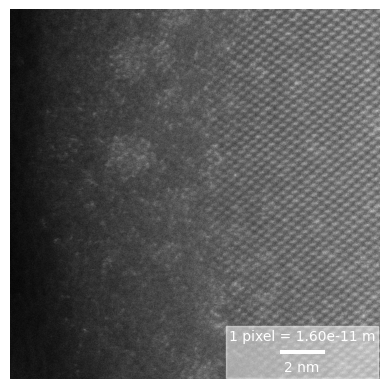

In [106]:
## take haadf finally
# get haadf from mic
# Get haadf
haadf_np_array, haadf_tiff_name = tf_acquisition.acquire_haadf(
    exposure=haadf_exposure, resolution=haadf_resolution
)

HAADF_tiff_to_png(haadf_tiff_name)
haadf = haadf_np_array

W, H = haadf.shape

In [107]:
## plot positons
positions = get_beam_positions( top_left_corner=(0.2, 0.5),
                    size_haadf_x=W,
                    size_haadf_y=H,
                    size_pixels_x_max=500,
                    size_pixels_y_max=100,
                    step_size_x=5,
                    step_size_y=5,)



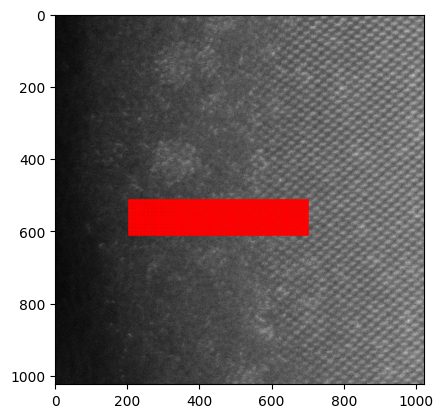

In [108]:
plot_beam_positions(haadf=haadf, positions=positions)

In [111]:
# save positons in disk
from datetime import datetime

current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
np.save(f"{out_path}pixel_pos_5-5-{current_time}.npy", positions)

In [ ]:
# run beam in the pattern
put_positions_on_mic_raster_right_to_left(positions=positions, num_rounds=5, per_position_exposure=10e-3)

In [112]:
scan_right_to_left_top_to_bottom(positions=positions, num_rounds=1, per_position_exposure=0.01)

2025-11-17 13:56:03,131 - INFO - Set beam position: old Point(x=-0.029980801, y=1.0107597)
2025-11-17 13:56:03,149 - INFO - UPDATED beam position: NewPoint(x=0.68339843, y=0.5)
2025-11-17 13:56:03,161 - INFO - Set beam position: old Point(x=0.68339843, y=0.5)
2025-11-17 13:56:03,178 - INFO - UPDATED beam position: NewPoint(x=0.68339843, y=0.50488281)
2025-11-17 13:56:03,191 - INFO - Set beam position: old Point(x=0.68339843, y=0.50488281)
2025-11-17 13:56:03,210 - INFO - UPDATED beam position: NewPoint(x=0.68339843, y=0.50976562)
2025-11-17 13:56:03,222 - INFO - Set beam position: old Point(x=0.68339843, y=0.50976562)
2025-11-17 13:56:03,239 - INFO - UPDATED beam position: NewPoint(x=0.68339843, y=0.51464844)
2025-11-17 13:56:03,251 - INFO - Set beam position: old Point(x=0.68339843, y=0.51464844)
2025-11-17 13:56:03,268 - INFO - UPDATED beam position: NewPoint(x=0.68339843, y=0.51953125)
2025-11-17 13:56:03,280 - INFO - Set beam position: old Point(x=0.68339843, y=0.51953125)
2025-11-

In [ ]:
## take haadf finally
# get haadf from mic
# Get haadf
haadf_np_array, haadf_tiff_name = tf_acquisition.acquire_haadf(
    exposure=haadf_exposure, resolution=haadf_resolution
)

HAADF_tiff_to_png(haadf_tiff_name)
haadf = haadf_np_array



## Later. Now Lets get localised haadf in the same box:
- haadf resolution:
    - size_x
    - size_y
- exposure- fast


In [ ]:
# from autoscript_tem_microscope_client.structures import adva
from autoscript_tem_microscope_client.structures import StemAcquisitionSettings, Rectangle, Region
from autoscript_tem_microscope_client.enumerations import  DetectorType, DetectorSegmentType, RegionCoordinateSystem.

In [ ]:
settings = StemAcquisitionSettings(1e-6,
                                    detector_types=[DetectorType.HAADF, DetectorType.BF_S],
                                    size=1024,
                                    auto_beam_blank=True)

In [ ]:
images = microscope.acquisition.acquire_stem_images_advanced(settings)


In [ ]:
# Show both images (1024x1024)
for image in images:
    plt.imshow(image.data, cmap='gray')
    plt.show()

In [ ]:
microscope.acquisition.acquire_stem_images_advanced

In [ ]:
## also get 4dstem acquisition AS-1.15 

In [ ]:
settings = StemAcquisitionSettings(2e-7,
                                   detector_types=[DetectorType.HAADF],
                                    region=Region(RegionCoordinateSystem.PIXELS, Rectangle(0, 2048, 4096, 2048)),
                                    auto_beam_blank=True)
images = microscope.acquisition.acquire_stem_images_advanced(settings)
# Show images
for image in images:
    plt.imshow(image.data, cmap='gray')
    plt.show()

In [ ]:
# Create settings and acquire images
# Combine enabled segments

# # Select segments from segmented detectors
# bf_s = microscope.detectors.get_scanning_detector(DetectorType.BF_S)
# bf_s.set_enabled_segments(DetectorSegmentType.OUTER_RING)

# df_s = microscope.detectors.get_scanning_detector(DetectorType.DF_S)
# df_s.set_enabled_segments(DetectorSegmentType.INNER_RING)

# segments = df_s.get_enabled_segments() + bf_s.get_enabled_segments()
settings = StemAcquisitionSettings(2e-7,
                                   detector_types=[DetectorType.HAADF],
                                    # detector_segments=segments,
                                    region=Region(RegionCoordinateSystem.PIXELS, Rectangle(0, 2048, 4096, 2048)),
                                    auto_beam_blank=True)

# Acquired 8 images (4096x2048)
images = microscope.acquisition.acquire_stem_images_advanced(settings)

# Show images
for image in images:
    plt.imshow(image.data, cmap='gray')
    plt.show()